# Make mock events, and evaluate the resulting strategy

After each run, you MUST restart your kernel

In [40]:
import os
import numpy as np
import pandas as pd
import scipy as sp
import sys
sys.path.append('/home/s/seanmacb/LSST-Camera/Extras and Utilities/pkgs')
sys.path.append('/home/s/seanmacb/LSST-Camera/Extras and Utilities/pkgs/eo_pipe/python/lsst/eo/pipe')
# import eo_pipe.python.lsst.eo.pipe as eo_pipe
# from eo_pipe.python.lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask, eperTask, divisaderoTearingTask, ptcPlotsTask,linearityPlotsTask, bfAnalysisTask)
import copy
import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from matplotlib import pyplot as plt
from lsst.ip.isr import IsrTask, IsrTaskConfig
plt.style.use("seaborn-v0_8-talk")
from matplotlib import lines
from mpl_toolkits import axes_grid1
from astropy.stats import sigma_clip
from scipy.stats import skew
import astropy
from tabulate import tabulate
from scipy.stats import norm
import healpy as hp

from lsst.obs.lsst import LsstCam, LsstTS8
from IPython.display import display_html, HTML
# import myutils_ar.myutils as myu

from astropy.time import Time
from collections import defaultdict
from datetime import datetime, timedelta
from scipy.stats import norm

# LSST Specific Libraries
from lsst_efd_client import EfdClient
from lsst.summit.utils.plotting import plot
from lsst.summit.utils.blockUtils import BlockParser
from lsst.summit.utils.efdUtils import makeEfdClient, getEfdData
from lsst.summit.utils.tmaUtils import (
    getCommandsDuringEvent,
    TMAEvent,
    TMAEventMaker,
    TMAState,
)
import matplotlib.dates as mdates

async def query_bump_logs_in_chunks(
    start_date,
    end_date,
    client_name="",
    chunk_size_days=3,
    topic_name="lsst.sal.MTM1M3.logevent_logMessage",
    fields=["message"],
):
    """
    Queries the log messages related to bump tests from the EFD in chunks.

    Args:
        start_date (str): Start date of the query in ISO format (YYYY-MM-DD).

        end_date (str): End date of the query in ISO format (YYYY-MM-DD).

        client_name (str, optional): Name of the EFD client. Defaults to "".

        chunk_size_days (int, optional): Number of days per chunk. Defaults to 3.

        topic_name (str, optional): SAL topic name to be queried by the client. Defaults to lsst.sal.MTM1M3.logevent_logMessage.

        fields (list[str], optional): Fields to be queried by the client. Defaults to ["message"].

    Returns:
        pandas.DataFrame: Concatenated DataFrame containing the queried log messages.
    """

    client = makeClient(client_name)

    # Convert start and end dates to datetime objects
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)

    # Initialize an empty DataFrame to store concatenated results
    all_data = pd.DataFrame()

    current_start = start
    while current_start < end:
        current_end = min(current_start + timedelta(days=chunk_size_days), end)
        try:
            # Query the data for the current chunk
            chunk_data = await client.select_time_series(
                topic_name=topic_name,
                fields=fields,
                start=Time(current_start.isoformat(), format="isot", scale="utc"),
                end=Time(current_end.isoformat(), format="isot", scale="utc"),
            )
            # Concatenate the chunk data to the main DataFrame
            all_data = pd.concat([all_data, chunk_data], ignore_index=False)
        except Exception as e:
            print(
                f"Error querying data from {current_start.isoformat()} to {current_end.isoformat()}: {e}"
            )
            continue  # Optionally, continue to the next chunk

        # Move to the next chunk
        current_start = current_end

    return all_data

from astropy.utils.iers import conf
conf.auto_max_age = None

def makeClient(client_name):
    # Create the client based on client_name
    if client_name == "summit_efd":
        return makeEfdClient("summit_efd")
    elif client_name == "usdf_efd":
        return makeEfdClient("usdf_efd")
    elif client_name == "idf_efd":
        return makeEfdClient("idf_efd")
    else:
        return makeEfdClient()  # Default client


# Example usage:
# begin = "2023-11-13T01:00"
# end = "2023-12-21T01:00"
# bump_logs = await query_bump_logs_in_chunks(begin, end, client_name='')

import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib') 
def showAndClear():
    plt.show()
    # Clear the current axes.
    plt.cla()
    # Clear the current figure.
    plt.clf()
    # Closes all the figure windows.
    plt.close("all")
    plt.close(fig)

    return


async def getDataFrame(client, starts, ends, topic, verbose=True, fields=None):

    all_data = pd.DataFrame()
    for start, end in zip(starts, ends):
        if verbose:
            print(
                r"Starting query for time range {} - {}".format(start, end),
                end=" . . . ",
            )
        if fields != None:
            df_bump = await client.select_time_series(
                topic, fields, Time(start), Time(end)
            )
        else:
            df_bump = await client.select_time_series(
                topic, "*", Time(start), Time(end)
            )

        all_data = pd.concat([all_data, df_bump], ignore_index=False)

        del df_bump

        if verbose:
            print("Finished")

    return all_data


def makeDateRange(startPoint, endPoint, step=np.timedelta64(1, "D")):
    starts = np.arange(startPoint, endPoint, step=step)
    ends = starts + np.timedelta64(1, "D")
    return starts, ends

def fitGaussian(data, ax):
    mu, std = norm.fit(data)

    xmin, xmax = ax.get_xlim()
    x = np.linspace(np.floor(xmin), np.ceil(xmax), int(10e4))
    p = norm.pdf(x, mu, std)

    return mu, std, p, x, xmin, xmax

def getFWHM_from_gaussian(sigma):
    return 2 * np.sqrt(np.log(2) * 2) * sigma

from astropy.time import Time
from astropy.coordinates import get_sun
import astropy.coordinates as coord
import astropy.units as u



from astropy.stats import mad_std
# instrument="LSSTCam"
# embargoButler = daf_butler.Butler("/repo/embargo",collections=['LSSTCam/raw/all','LSSTCam/calib'])
# mainButler = daf_butler.Butler("/repo/main",collections=['LSSTCam/raw/all','LSSTCam/calib/unbounded'])
# flatColl = "LSSTCam/calib/DM-50448/initial-ugr-flats/flatGen-u.20250423a"
# # flat_det184 = embargoButler.get("flat",collections=flatColl,detector=184,instrument=instrument,physical_filter="i_39")
# isrConfig = IsrTaskConfig()
# isrConfig.doLinearize=False
# isrConfig.doOverscan=True
# isrConfig.overscan.fitType="MEDIAN_PER_ROW"
# isrConfig.overscan.doParallelOverscan=True
# isrConfig.doAssembleCcd=True
# isrConfig.doBias=False
# isrConfig.doVariance=False
# isrConfig.doCrosstalk=False
# isrConfig.doBrighterFatter=False
# isrConfig.doDark=False
# isrConfig.doStrayLight=False
# isrConfig.doFlat=False
# isrConfig.doFringe=False
# isrConfig.doApplyGains=True
# isrConfig.usePtcGains=False
# isrConfig.doDefect=False
# isrConfig.doNanMasking=True
# isrConfig.doInterpolate=False
# isrConfig.doSaturation=False
# isrConfig.doSaturationInterpolation=False
# isrTask = IsrTask(config=isrConfig)

In [41]:
async def query_bump_logs_in_chunks(
    start_date, end_date, client_name="", chunk_size_days=3,topic_name="lsst.sal.MTM1M3.logevent_logMessage",fields=["message"]
):
    """
    Queries the log messages related to bump tests from the EFD in chunks.

    Args:
        start_date (str): Start date of the query in ISO format (YYYY-MM-DD).
        
        end_date (str): End date of the query in ISO format (YYYY-MM-DD).
        
        client_name (str, optional): Name of the EFD client. Defaults to "".
        
        chunk_size_days (int, optional): Number of days per chunk. Defaults to 3.

        topic_name (str, optional): SAL topic name to be queried by the client. Defaults to lsst.sal.MTM1M3.logevent_logMessage.

        fields (list[str], optional): Fields to be queried by the client. Defaults to ["message"].

    Returns:
        pandas.DataFrame: Concatenated DataFrame containing the queried log messages.
    """

    client = makeClient(client_name)

    # Convert start and end dates to datetime objects
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)

    # Initialize an empty DataFrame to store concatenated results
    all_data = pd.DataFrame()

    current_start = start
    while current_start < end:
        current_end = min(current_start + timedelta(days=chunk_size_days), end)
        try:
            # Query the data for the current chunk
            chunk_data = await client.select_time_series(
                topic_name=topic_name,
                fields=fields,
                start=Time(current_start.isoformat(), format="isot", scale="utc"),
                end=Time(current_end.isoformat(), format="isot", scale="utc"),
            )
            # Concatenate the chunk data to the main DataFrame
            all_data = pd.concat([all_data, chunk_data], ignore_index=False)
        except Exception as e:
            print(
                f"Error querying data from {current_start.isoformat()} to {current_end.isoformat()}: {e}"
            )
            continue  # Optionally, continue to the next chunk

        # Move to the next chunk
        current_start = current_end

    return all_data

def makeClient(client_name):
        # Create the client based on client_name
    if client_name == "summit_efd":
        return makeEfdClient("summit_efd")
    elif client_name == "usdf_efd":
        return makeEfdClient("usdf_efd")
    elif client_name == "idf_efd":
        return makeEfdClient("idf_efd")
    elif client_name == "base_efd":
        return makeEfdClient("base_efd")
    else:
        return makeEfdClient()  # Default client


# Example usage:
# begin = "2023-11-13T01:00"
# end = "2023-12-21T01:00"
# bump_logs = await query_bump_logs_in_chunks(begin, end, client_name='')

def showAndClear():
    plt.show()
    # Clear the current axes.
    plt.cla() 
    # Clear the current figure.
    plt.clf() 
    # Closes all the figure windows.
    plt.close('all')   
    plt.close(fig)
    
    return

async def getDataFrame(client,starts,ends,topic,verbose=True,fields=None):
    
    all_data = pd.DataFrame()
    for start,end in zip(starts,ends):
        if verbose:
            print(r"Starting query for time range {} - {}".format(start,end),end=" . . . ")
        if fields != None:
            df_bump = await client.select_time_series(topic,fields, Time(start), Time(end))
        else:
            df_bump = await client.select_time_series(topic,"*", Time(start), Time(end))
        
        all_data = pd.concat([all_data, df_bump], ignore_index=False)

        del df_bump

        if verbose:
            print("Finished")
    
    return all_data

def makeDateRange(startPoint,endPoint,step=np.timedelta64(1, 'D')):
    starts = np.arange(startPoint,endPoint,step=step)
    ends = starts + np.timedelta64(1, 'D')
    return starts,ends

def fitGaussian(data,ax):
    mu, std = norm.fit(data) 
    
    xmin, xmax = ax.get_xlim()
    x = np.linspace(np.floor(xmin), np.ceil(xmax), int(10E4))
    p = norm.pdf(x, mu, std)

    return mu,std,p,x,xmin,xmax

def getFWHM_from_gaussian(sigma):
    return 2*np.sqrt(np.log(2)*2)*sigma

In [42]:
client = makeClient("summit",)
# client.db_name = "lsst.scimma"
a = await client.get_fields("lsst.sal.ESS.temperature")

In [45]:
t = await client.get_topics()

In [28]:
client.db_name = "lsst.scimma"

In [29]:
d = await client.get_schema("lsst.scimma.too_alert")

RegistryBadRequestError: Registry error (404). 40401 - Subject 'lsst.scimma.too_alert-value' not found.

In [ ]:
d

In [66]:
a

['alert_type',
 'event_trigger_timestamp',
 'instrument0',
 'instrument1',
 'instrument2',
 'is_test',
 'is_update',
 'reward_map0',
 'reward_map1',
 'reward_map10',
 'reward_map100',
 'reward_map1000',
 'reward_map10000',
 'reward_map10001',
 'reward_map10002',
 'reward_map10003',
 'reward_map10004',
 'reward_map10005',
 'reward_map10006',
 'reward_map10007',
 'reward_map10008',
 'reward_map10009',
 'reward_map1001',
 'reward_map10010',
 'reward_map10011',
 'reward_map10012',
 'reward_map10013',
 'reward_map10014',
 'reward_map10015',
 'reward_map10016',
 'reward_map10017',
 'reward_map10018',
 'reward_map10019',
 'reward_map1002',
 'reward_map10020',
 'reward_map10021',
 'reward_map10022',
 'reward_map10023',
 'reward_map10024',
 'reward_map10025',
 'reward_map10026',
 'reward_map10027',
 'reward_map10028',
 'reward_map10029',
 'reward_map1003',
 'reward_map10030',
 'reward_map10031',
 'reward_map10032',
 'reward_map10033',
 'reward_map10034',
 'reward_map10035',
 'reward_map10036',


In [47]:
start = Time("2025-07-25T19:30:16.20")
end = Time("2025-07-26T17:20")

In [48]:
# too_alert = await client.select_time_series("lsst.scimma.too_alert",a,start,end)
tempData = await client.select_time_series("lsst.sal.ESS.temperature",a,start,end)

In [57]:
filteredTempData = tempData[tempData["salIndex"]==2]

In [70]:
def makeSkymapArr(row):
    msk = [x.__contains__("reward_map") and (not x.__contains__("nside")) for x in list(row.index)]
    myArr = row.index[msk]
    sorted_labels = myArr[np.argsort([int(s.split("reward_map")[1]) for s in myArr])]
    flattenedArr = row[sorted_labels].values
    return flattenedArr.astype(bool)

def makeSkymapPlot(flattened,infoString=""):
    hp.mollview(flattened,title=infoString,nest=True)

def makeInfoString(row):
    infoKeys = ["alert_type","event_trigger_timestamp","is_test","is_update","source"]
    startString = ""
    for key in infoKeys:
        startString+="{}: {}\n".format(key,row[key])
    return startString

In [71]:
row = too_alert.iloc[-1]

In [72]:
alertPacket = {}
instArr = []
for key,val in zip(row.keys(),row.values):
    if not (key.__contains__("instrument") or key.__contains__("reward_map")):
        if type(val)==np.bool_:
            alertPacket[key] = bool(val)
        elif type(val)==np.int_:
            alertPacket[key]=int(val)
        else:
            alertPacket[key] = val
    elif key.__contains__("instrument") and val!=None:
        instArr.append(val)
tmpList = []
for entry in makeSkymapArr(row):
    tmpList.append(int(entry))
alertPacket["reward_map"] = tmpList
alertPacket['instrument'] = instArr

In [73]:
alertPacket

{'alert_type': 'GW_case_B',
 'event_trigger_timestamp': '2025-07-25T19:44:46.673Z',
 'is_test': False,
 'is_update': False,
 'source': 'S250725j_test_1',
 'timestamp': 1753472700490,
 'reward_map': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [75]:
file_path = "S250728j_alertPacket_efd.json"
with open(file_path, "w") as json_file:
    json.dump(alertPacket, json_file, indent=4)

90% area in deg^2: 26.8573977342742


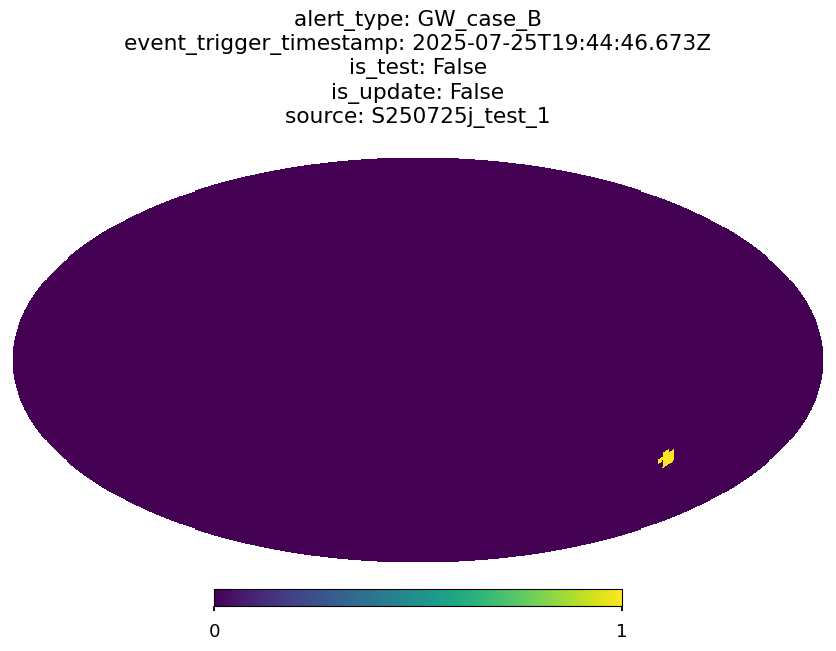

In [61]:
for _,row in too_alert.iterrows():
    flattenedArray = makeSkymapArr(row)
    infoString = makeInfoString(row)
    makeSkymapPlot(flattenedArray,infoString=makeInfoString(row))
    print("90% area in deg^2:",len(np.where(flattenedArray>0)[0])*1.0226539E-3*(180/np.pi)**2)
    plt.show()
    plt.close()

In [62]:
ra_dec = []
for entry,ipix in zip(flattenedArray,range(len(flattenedArray))):
    if entry!=0:
        ra_dec.append(hp.vec2dir(hp.pix2vec(32,ipix,nest=True),lonlat=True))

In [46]:
np.median(ra_dec,axis=0)

array([-126.5625    ,  -35.68533471])

In [47]:
np.min(ra_dec,axis=0),np.max(ra_dec,axis=0)

(array([-130.78125   ,  -38.68218745]), array([-122.34375  ,  -32.7971683]))

In [48]:
ra_dec

[array([-127.96875   ,  -38.68218745]),
 array([-130.78125   ,  -38.68218745]),
 array([-129.375     ,  -37.16889966]),
 array([-125.15625   ,  -38.68218745]),
 array([-123.75      ,  -37.16889966]),
 array([-122.34375   ,  -35.68533471]),
 array([-126.5625    ,  -37.16889966]),
 array([-125.15625   ,  -35.68533471]),
 array([-127.96875   ,  -35.68533471]),
 array([-126.5625    ,  -34.22886633]),
 array([-123.75      ,  -34.22886633]),
 array([-125.15625  ,  -32.7971683]),
 array([-130.78125   ,  -35.68533471]),
 array([-129.375     ,  -34.22886633])]

In [49]:
np.shape(ra_dec)

(14, 2)